# Model evaluation and drawing sheeeet

In [1]:
from models import *
from utils import set_seed
from data.loaders import * 

In [2]:
user = 'ajimenez'

In [3]:
path_to_model = f"/home/{user}/CoSE-pytorch/wandb/run-20210128_122647-3iw8z8ml/files/weights_trained"

In [4]:
set_seed(0)
device = torch.device('cuda:2')
cose = CoSEModel('config.json', False)
cose.encoder.load_state_dict(torch.load(os.path.join(os.getcwd(), path_to_model,"epoch_2/encoder.pth"), map_location=device))
cose.decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model ,"epoch_2/decoder.pth"), map_location=device))
cose.position_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"epoch_2/pos_pred.pth"), map_location=device))
cose.embedding_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"epoch_2/emb_pred.pth"), map_location=device))

<All keys matched successfully>

In [5]:
val_path = f"/data/{user}/cose/valid/"

In [6]:
batchdata = BatchCoSELoader(path = val_path,
                    filenames={"inputs_file" : "valid_inputs_list_based_x16.pkl",
                                "targets_file": "valid_target_list_based_x16.pkl"}
                )

valid_loader = DataLoader(dataset =batchdata,
                batch_size = 1, #data is already in batch mode, batch_size = 1 means iterating every .get_next() returns a new batch
                )

In [7]:
from utils.visualization import * 

In [8]:
stats_json = 'didi_wo_text-stats-origin_abs_pos.json'
stats_path = '/data/jcabrera/didi_wo_text/'
with open(os.path.join(stats_path, stats_json)) as json_file:
    stats = json.load(json_file)

In [9]:
mean_channel = stats['mean_channel'][:2]
std_channel = np.sqrt(stats['var_channel'][:2])

In [10]:
log_dir = f'/home/ajimenez/pruebas'

In [11]:
for batch_input, batch_target in iter(valid_loader):
    break

In [12]:
i_diagram = 7

In [13]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0)
seq_len_drawing = batch_input['seq_len'].squeeze(dim = 0)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze()

In [14]:
enc_inputs = encoder_inputs.reshape(-1, num_strokes.max(), encoder_inputs.size(1), encoder_inputs.size(2))
seq_len = seq_len_drawing.reshape(-1, num_strokes.max())
st_coord = start_coord.reshape(-1,num_strokes.max(), start_coord.size(1))

In [15]:
i_diagram = 5

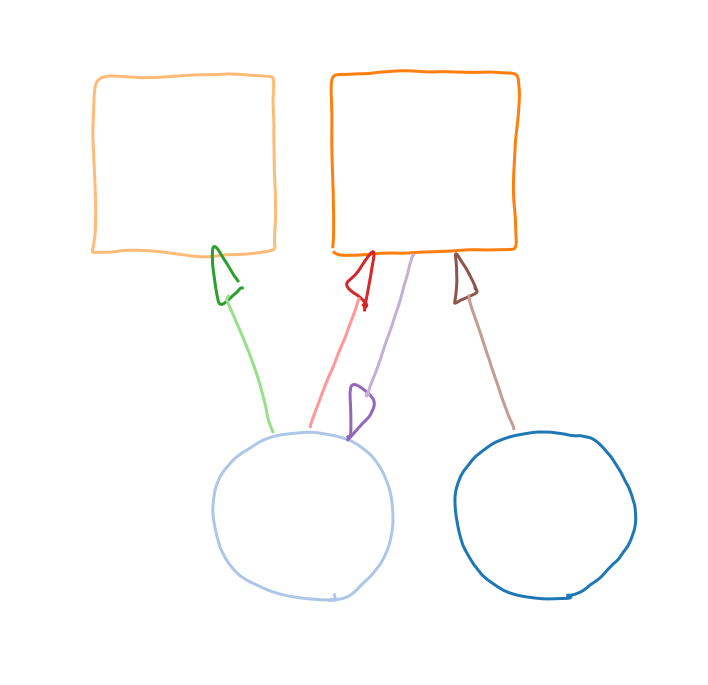

In [16]:
npfig, fig, _ = transform_strokes_to_image(enc_inputs[i_diagram], seq_len[i_diagram], st_coord[i_diagram],
                                    mean_channel, std_channel, num_strokes[i_diagram],log_dir, 'noutput_pruebas', square_figure=True) #, alpha=0.5, highlight_start=True)

## Pasando data por el modelo

In [17]:
device = "cuda:2"

In [40]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0).to(device)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0).to(device)
strok_len_inputs = batch_input['seq_len'].squeeze(dim = 0).to(device)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze().to(device)
end_coord = batch_input['end_coord'].squeeze(dim = 0).squeeze().to(device)

In [42]:
strok_len_inputs

tensor([ 60,  12,  75,  13,  79,  12,  20,  99,   0,   0,   0,   0, 131,  24,
         70, 164,  19,  76, 156,  18,  73, 127,   0,   0, 106,  93,  95,  81,
         26,  16,  30,  16,  25,  23,  26,  18,  78,  11,  46,  94,  88,  11,
         46,  13,  49,  63, 135,   0,  39,  11,  18,  11,  11,   9,  12,   8,
         35,  51,  17,  98, 128, 115, 151, 162,  42,  31,  44,  25,  39,  35,
         39,  24,  78,  83,  86, 116,   9,  97,  18, 111,  82, 129,  83,   0,
         56,  14,  65,  76,  79,  20,  53,  47, 128,  81,  53,   0],
       device='cuda:2')

In [19]:
encoder_inputs.shape

torch.Size([96, 164, 3])

In [20]:
_, look_ahead_mask, _ = generate_3d_mask(encoder_inputs, strok_len_inputs,'cuda:2')

In [21]:
encoder_out = cose.encoder(encoder_inputs.permute(1,0,2), strok_len_inputs, look_ahead_mask)

In [22]:
encoder_out.shape

torch.Size([96, 8])

In [39]:
encoder_out[8],
strok_len_inputs[8]

tensor(0, device='cuda:2')

In [77]:
from chamferdist import ChamferDistance
for get_reconstruction_metrics(batch_encoder_out, strok_len_inputs):
    loss_ae = 0
    chamf_dist = 0
    q = 0
    for i, stroke_embedding in enumerate(encoder_out):
        if strok_len_inputs[i] > 0:
            t_inputs = torch.linspace(0, 1, steps=strok_len_inputs[i]).to(device)
            t_inp = t_inputs.reshape(1,-1)
            stroke_emb = stroke_embedding.reshape(1,-1).repeat(t_inp.size(-1), 1)
            t_inp = t_inp.reshape(-1,1)
            recons_input = torch.cat([stroke_emb, t_inp], dim = 1)
            try:
                recons_stroke, ae_mu, ae_sigma, ae_pi= cose.decoder(recons_input)
            except:
                print(i)
                print(recons_input)
            orig_stroke_ = encoder_inputs[i:i+1,:strok_len_inputs[i],:2]
            recon_stroke_ = recons_stroke.reshape(-1, strok_len_inputs[i],2)
            loss_ae += -1*(logli_gmm_logsumexp(encoder_inputs[i:i+1,:strok_len_inputs[i],:2], ae_mu, ae_sigma, ae_pi).mean())
            chamfer_dist = chamferDist(orig_stroke_, recon_stroke_).detach().cpu().item()
            q+=1
    loss_ae = loss_ae/q
    chamf_dist = chamfer_dist/q

CPU times: user 156 ms, sys: 20.8 ms, total: 177 ms
Wall time: 177 ms


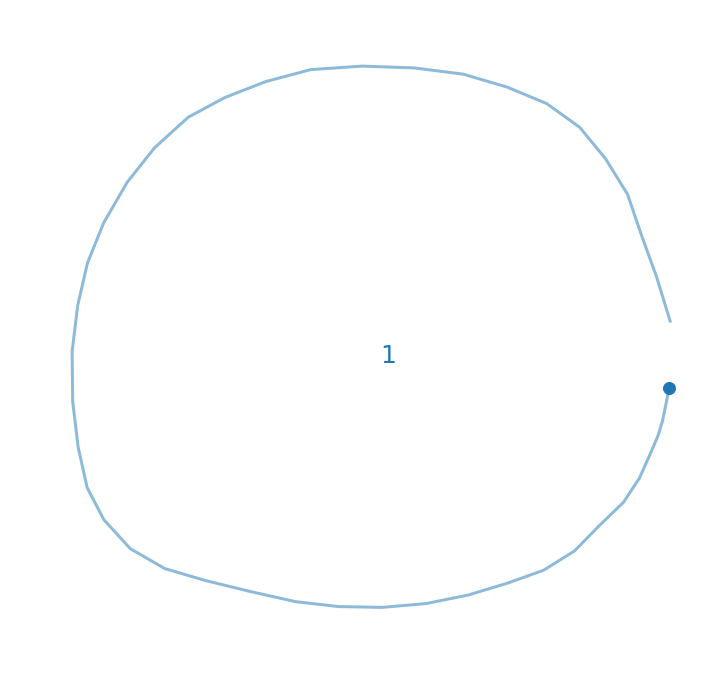

In [47]:
np_fig,fig_out, _ = transform_strokes_to_image(orig_stroke_.cpu().detach(), [45], start_coord[i].unsqueeze(dim = 0).cpu().detach(),
                                    mean_channel, std_channel, None, log_dir, 'noutput_pruebas', square_figure=True, alpha=0.5, highlight_start=True)

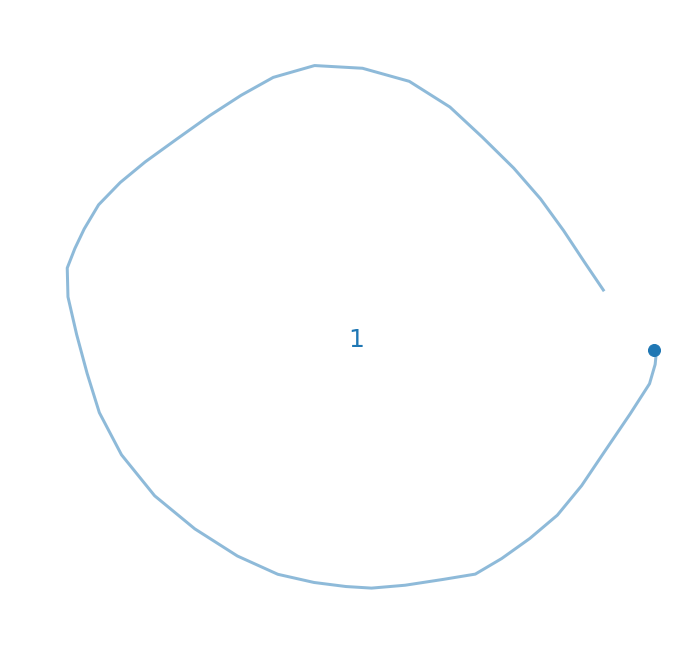

In [48]:
np_fig,fig_out, _ = transform_strokes_to_image(recon_stroke_.cpu().detach(), [45], start_coord[i].unsqueeze(dim = 0).cpu().detach(),
                                    mean_channel, std_channel, None, log_dir, 'noutput_pruebas', square_figure=True, alpha=0.5, highlight_start=True)

In [50]:
diagram_embedding, padded_max_num_strokes, _, num_diagrams = reshape_stroke2diagram(encoder_out,num_strokes)

In [51]:
start_pos_base = start_coord.reshape(num_diagrams,padded_max_num_strokes,2)

In [52]:
pos_model_inputs = torch.cat([diagram_embedding, start_pos_base], dim = 2)

In [53]:
pos_pred_mu, pos_pred_sigma, pos_pred_pi = cose.position_predictive_model(pos_model_inputs, num_strokes, None)

In [54]:
pos_model_output = cose.position_predictive_model.draw_sample(pos_pred_mu, pos_pred_sigma, pos_pred_pi)

In [55]:
pred_model_inputs = torch.cat([diagram_embedding, start_pos_base, pos_model_output.unsqueeze(dim = 1).repeat(1, diagram_embedding.size(1), 1)], dim = 2)

In [56]:
emb_pred_mu, emb_pred_sigma, emb_pred_pi = cose.embedding_predictive_model(pred_model_inputs, num_strokes, None)

In [57]:
strokes_output = cose.embedding_predictive_model.draw_sample(emb_pred_mu, emb_pred_sigma, emb_pred_pi)

In [58]:
strokes_output.shape

torch.Size([8, 8])

In [59]:
points_q = 6

In [60]:
t_inputs = torch.linspace(0, 1, steps=points_q)
t_inputs=t_inputs.unsqueeze(dim=0).repeat(strokes_output.shape[0],1)
t_inputs=t_inputs.reshape((-1, 1))
strokes_output_r=strokes_output.repeat(points_q,1)
strokes_output_r.shape
t_inputs= t_inputs.to(device)
strokes_out = torch.cat([strokes_output_r, t_inputs], dim=1)


#flatten t_inputs (48, 1)
#repeat or tile strokes_output (batch_sizexpoints_q, 8) -> (48,8)
#concat t_inputs + strokes_output_reshapeo #(batch_sizexpoints_q, 9)
# entra al decoder
#draw sample del decoder

In [61]:
strokes_out, ae_mu, ae_sigma, ae_pi= cose.decoder(strokes_out)

In [63]:
drawing_out = strokes_out.reshape(-1,points_q,2)

In [71]:
drawing_out[i_diagram].unsqueeze(dim = 0).shape

torch.Size([1, 6, 2])

In [34]:
seq_len_out = (torch.ones((drawing_out.shape[0]))*points_q).int()

In [75]:
[seq_len_out[i_diagram]]

[tensor(6, dtype=torch.int32)]

In [35]:
drawing_out_cpu = drawing_out.cpu().detach()#.numpy()
pos_model_output_cpu = pos_model_output.cpu().detach()#.numpy()

In [78]:
#check_again

In [101]:
encoder_inputs.reshape(-1, padded_max_num_strokes, encoder_inputs.size(1), encoder_inputs.size(2))[i_diagram].shape

torch.Size([12, 164, 3])

In [102]:
drawing_i.shape

torch.Size([1, 6, 2])

In [91]:
drawing_i = drawing_out_cpu[i_diagram].unsqueeze(dim = 0)
start_coor_i = [pos_model_output_cpu[i_diagram]]
len_i  = [seq_len_out[i_diagram]]

In [106]:
drawing_i

tensor([[[-0.2522, -0.2008],
         [ 0.1434,  0.1132],
         [ 0.2259,  0.3366],
         [ 0.3154,  0.6044],
         [ 0.1262,  0.2051],
         [ 0.2116,  0.8331]]])

In [107]:
start_coor_i

[tensor([1.2675, 0.4312])]

In [108]:
len_i

[tensor(6, dtype=torch.int32)]

In [92]:
# if drawing_out_cpu.shape[2] == 2:
#     drawing_out_cpu = np.concatenate([drawing_out_cpu, torch.zeros(drawing_out_cpu.size(0), drawing_out_cpu.size(1), 1)], axis = -1)
# drawing_out_cpu

In [ ]:
#[, asd , ]

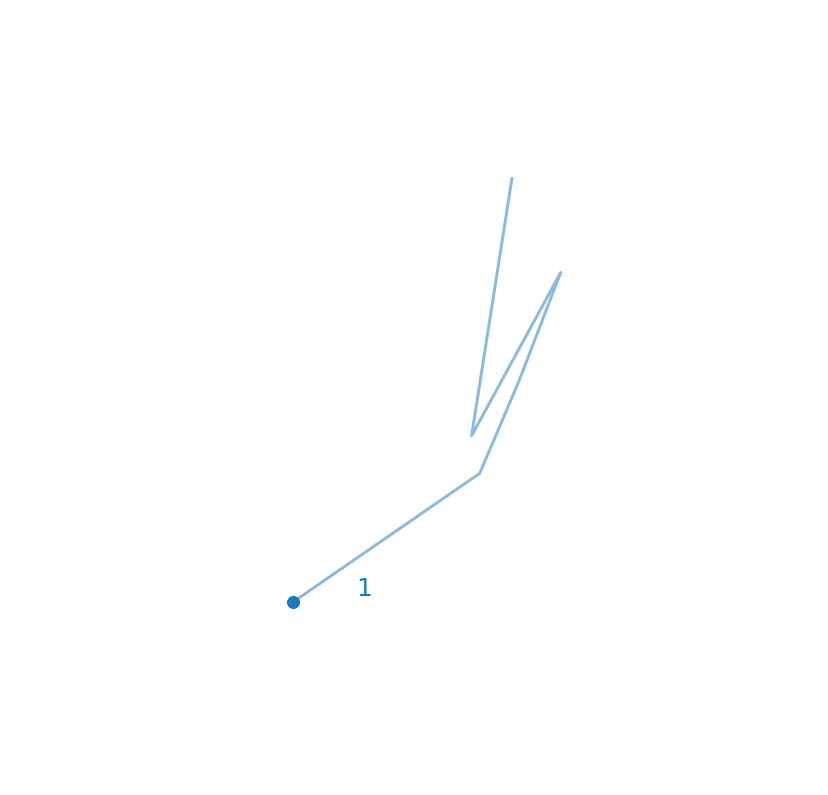

In [96]:
np_fig,fig_out, _ = transform_strokes_to_image(drawing_i, len_i, start_coor_i,
                                    mean_channel, std_channel, drawing_i.shape[0], log_dir, 'noutput_pruebas', square_figure=True, alpha=0.5, highlight_start=True)

In [38]:
np_fig.shape

(1100, 1100, 4)

In [39]:
%matplotlib inline

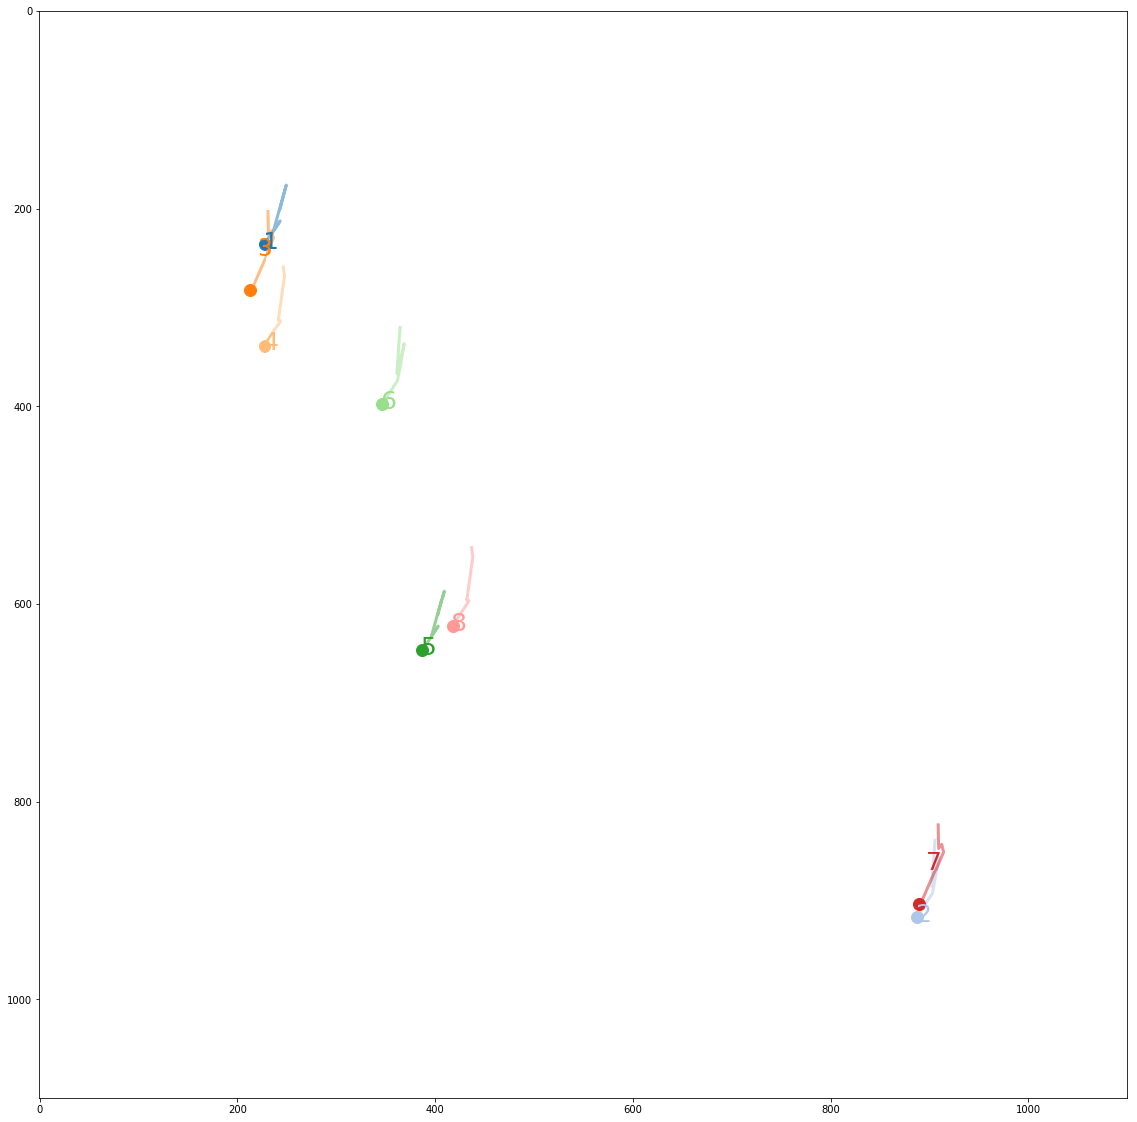

In [43]:
plt.figure(figsize = (20,20))
plt.imshow(np_fig,)

In [1]:
from data.loaders import *

In [2]:
from utils import * 

In [4]:
data_loader = get_batch_iterator("/data/ajimenez/cose/train")

In [5]:
for batch_input, batch_target in iter(data_loader):
    print(batch_input['seq_len'].shape)
    sys.exit(0)

torch.Size([1, 96])


NameError: name 'sys' is not defined

In [12]:
batch_input['encoder_inputs'][0][3]

tensor([[-0.3041, -0.2503,  0.0000],
        [-0.4012, -0.4150,  0.0000],
        [-0.4784, -0.5985,  0.0000],
        [-0.5537, -0.7905,  0.0000],
        [-0.6289, -0.9824,  0.0000],
        [-0.6912, -1.1436,  0.0000],
        [-0.7417, -1.2636,  0.0000],
        [-0.7781, -1.3270,  0.0000],
        [-0.8084, -1.3429,  0.0000],
        [-0.8336, -1.3170,  0.0000],
        [-0.8636, -1.2630,  0.0000],
        [-0.9032, -1.1738,  0.0000],
        [-0.9560, -1.0703,  0.0000],
        [-1.0152, -0.9718,  0.0000],
        [-1.0801, -0.8670,  0.0000],
        [-1.1302, -0.7882,  0.0000],
        [-1.1652, -0.7264,  0.0000],
        [-1.1786, -0.6887,  0.0000],
        [-1.1768, -0.6673,  0.0000],
        [-1.1597, -0.6535,  0.0000],
        [-1.1239, -0.6323,  0.0000],
        [-1.0716, -0.5946,  0.0000],
        [-1.0104, -0.5299,  0.0000],
        [-0.9465, -0.4376,  0.0000],
        [-0.8798, -0.3120,  0.0000],
        [-0.8301, -0.1725,  0.0000],
        [-0.7940, -0.0368,  0.0000],
 